###### [OpenCV实战（4）——文档扫描OCR识别&答题卡识别判卷（文档扫描，图像矫正，透视变换，OCR识别）](https://www.cnblogs.com/wj-1314/p/11975977.html)



[github](https://github.com/LeBron-Jian/ComputerVisionPractice/blob/master/ImageProcessingPractice4/complete_exmple2.py)

In [3]:
import cv2
import numpy as np
from PIL import Image
import pytesseract
from matplotlib import pyplot as plt
import numpy as np

In [21]:

def show(image):
    plt.imshow(image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

def resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w*r), height)
    else:
        r = width / float(w)
        dim = (width, int(h*r))
    resized = cv2.resize(image, dim, interpolation=inter)
    return resized

In [10]:
def show2(image):
    """
    使用 Matplotlib 显示图像

    Args:
        image: OpenCV 格式的图像

    Returns:
        None
    """

    # OpenCV 图像一般是 BGR 格式，Matplotlib 显示需要 RGB 格式
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # 显示原始图像
    plt.figure(figsize=(10, 5))
    # plt.axis('off')  # 关闭坐标轴
    plt.show()

In [32]:
def edge_detection(img_path):
    # *********  预处理 ****************
    # 读取输入
    img = cv2.imread(img_path)
    # 坐标也会相同变换
    ratio = img.shape[0] / 500.0
    orig = img.copy()

    image = resize(orig, height=500)
    # 预处理
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blur, 75, 200)

    # *************  轮廓检测 ****************
    # 轮廓检测
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # 遍历轮廓
    for c in cnts:
        # 计算轮廓近似
        peri = cv2.arcLength(c, True)
        # c表示输入的点集，epsilon表示从原始轮廓到近似轮廓的最大距离，它是一个准确度参数
        approx = cv2.approxPolyDP(c, 0.02*peri, True)

        # 4个点的时候就拿出来
        if len(approx) == 4:
            screenCnt = approx
            break

    # res = cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    # res = cv2.drawContours(image, cnts[0], -1, (0, 255, 0), 2)
    # show(orig)
    return orig, ratio, screenCnt

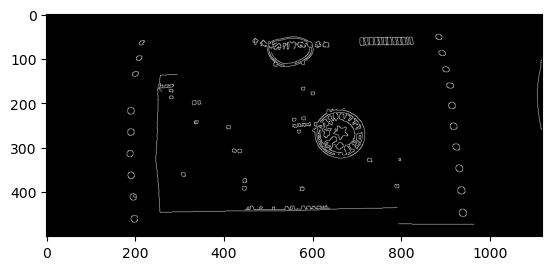

<Figure size 1000x500 with 0 Axes>

In [20]:
edge_detection('./images/1.jpg')

In [30]:
def order_points(pts):
    # 一共四个坐标点
    rect = np.zeros((4, 2), dtype='float32')
     
    # 按顺序找到对应的坐标0123 分别是左上，右上，右下，左下
    # 计算左上，由下
    # numpy.argmax(array, axis) 用于返回一个numpy数组中最大值的索引值
    s = pts.sum(axis=1)  # [2815.2   1224.    2555.712 3902.112]
    print(s)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
 
    # 计算右上和左
    # np.diff()  沿着指定轴计算第N维的离散差值  后者-前者
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect
 
 
# 透视变换
def four_point_transform(image, pts):
    # 获取输入坐标点
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
 
    # 计算输入的w和h的值
    widthA = np.sqrt(((br[0] - bl[0])**2) + ((br[1] - bl[1])**2))
    widthB = np.sqrt(((tr[0] - tl[0])**2) + ((tr[1] - tl[1])**2))
    maxWidth = max(int(widthA), int(widthB))
 
    heightA = np.sqrt(((tr[0] - br[0])**2) + ((tr[1] - br[1])**2))
    heightB = np.sqrt(((tl[0] - bl[0])**2) + ((tl[1] - bl[1])**2))
    maxHeight = max(int(heightA), int(heightB))
 
    # 变化后对应坐标位置
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]],
        dtype='float32')   
 
    # 计算变换矩阵
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
 
    # 返回变换后的结果
    return warped
 
 
# 对透视变换结果进行处理
def get_image_processingResult(img_path):
    # img_path = 'images/receipt.jpg'
    orig, ratio, screenCnt = edge_detection(img_path)
    # screenCnt 为四个顶点的坐标值，但是我们这里需要将图像还原，即乘以以前的比率
    # 透视变换  这里我们需要将变换后的点还原到原始坐标里面
    warped = four_point_transform(orig, screenCnt.reshape(4, 2)*ratio)
    # 二值处理
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]
 
    thresh_resize = resize(thresh, height = 400)
    show(thresh_resize)

[1188.33 1215.5  1259.83 1232.66]


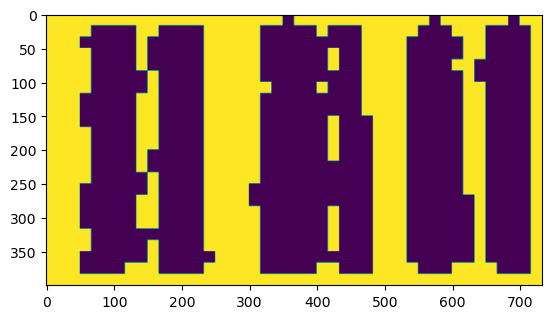

In [33]:
 # 获取矫正之后的图片
get_image_processingResult('./images/1.jpg')

In [35]:
def ocr_recognition(filename='tes.jpg'):
    img = Image.open(filename)
    text = pytesseract.image_to_string(img)
    print(text)

In [36]:
 # 获取矫正之后的图片
    # get_image_processingResult()
    # 进行OCR文字识别
ocr_recognition(filename='images/1.jpg')
